In [266]:
from PIL import Image
import tensorflow as tf 
import numpy as np
import cv2
import time 

In [267]:
sess = tf.compat.v1.InteractiveSession()
# Load image in 
tf_img = tf.keras.preprocessing.image.load_img('out.png')
cols, rows = tf_img.size

# Initialise S 
S = tf.Variable(np.array(tf_img), dtype=np.float32)
S = S.assign(S/256)

size_2D = (rows, cols)
fx = tf.constant([1, -1], dtype=np.int32)

fx = np.int32([[1, -1]])
fy = np.int32([[1], [-1]])

In [255]:
def psf2otf(psf, outSize):
    print(outSize)

    psf = np.float32(psf)

    # Determine PSF / OTF shapes
    psfSize = np.int32(psf.shape)

    # Pad the PSF to outSize
    new_psf = np.zeros(outSize, dtype=np.float32)
    
    
    
    new_psf[:psfSize[0],:psfSize[1]] = psf[:,:]
    psf = new_psf
    
    print(new_psf.shape)

    # Circularly shift the OTF so that PSF center is at (0,0)
    shift = -(psfSize / 2)
    
    for i in range(shift.size):
        psf = np.roll(psf, int(shift[i]), axis=i)
    
    otf = np.fft.fftn(psf)
    return otf

In [256]:
otfFx = psf2otf(fx, size_2D)
otfFy = psf2otf(fy, size_2D)

(480, 640)
(480, 640)
(480, 640)
(480, 640)


In [257]:
otfFx = tf.complex(otfFx.real, otfFx.imag)
otfFy = tf.complex(otfFy.real, otfFy.imag)

In [258]:
_lambda = 2e-2
kappa = 2.0

# Compute F(I)
S_complex = tf.Variable(tf.complex(S, tf.constant(tf.zeros((rows, cols, 3)))))
S_complex = tf.cast(S_complex, dtype=tf.complex128)
S_complex = tf.Variable(S_complex)

FI = tf.Variable(tf.complex(tf.zeros((rows, cols, 3)), tf.zeros((rows, cols, 3))))

FI = tf.cast(FI, dtype=tf.complex128)
FI = tf.Variable(FI)
for i in range(S_complex.shape[2]):
    FI = FI[:,:,i].assign(tf.cast(tf.signal.fft2d(S_complex[:,:,i]), dtype=tf.complex128))

In [259]:
MTF = tf.math.square(tf.math.abs(otfFx)) + tf.math.square(tf.math.abs(otfFy))
MTF = tf.stack([MTF, MTF, MTF], axis=2)

In [260]:
# Initialize buffers
# h = tf.complex(tf.zeros((rows, cols, 3)), tf.zeros((rows, cols, 3)))
# v = tf.complex(tf.zeros((rows, cols, 3)), tf.zeros((rows, cols, 3)))

h = tf.Variable(tf.zeros((rows, cols, 3), dtype=tf.float64))
v = tf.Variable(tf.zeros((rows, cols, 3), dtype=tf.float64))
dxhp = tf.Variable(tf.zeros((rows, cols, 3), dtype=tf.float64))
dyvp = tf.Variable(tf.zeros((rows, cols, 3), dtype=tf.float64))
FS = tf.Variable(tf.complex(tf.zeros((rows, cols, 3), dtype=tf.float64), 
                            tf.zeros((rows, cols, 3), dtype=tf.float64) ))
FS = tf.cast(FS, dtype=tf.complex128)

# # Iteration settings
beta_max = 1e5;
beta = 2 * _lambda
iteration = 0

In [261]:
M = cols
N = rows 

In [262]:
# Iterate until desired convergence in similarity
while beta < beta_max:
    h = tf.Variable(h)
    v = tf.Variable(v)

    # compute dxSp
    h = h[:,0:M-1,:].assign(tf.cast(tf.math.real(S_complex[:,1:]-S_complex[:,:-1]), dtype=tf.float64))
    h = h[:,M-1:M,:].assign(tf.cast(tf.math.real(S_complex[:,0:1,:] - S_complex[:,M-1:M,:]), dtype=tf.float64))

    # compute dySp
    v = v[0:N-1,:,:].assign(tf.cast(tf.math.real(S_complex[1:]-S_complex[:-1]), dtype=tf.float64))
    v = v[N-1:N,:,:].assign(tf.cast(tf.math.real(S_complex[0:1,:,:] - S_complex[N-1:N,:,:]), dtype=tf.float64))
    
    # compute minimum energy E = dxSp^2 + dySp^2 <= _lambda/beta
    t = tf.reduce_sum(tf.math.square(h) + tf.math.square(v), axis=2) < _lambda / beta
    t = tf.stack([t, t, t], axis=2)

    # compute piecewise solution for hp, vp
    idx = tf.where(t)
    h = tf.tensor_scatter_nd_update(h, idx, tf.zeros(idx.shape[0], dtype=tf.float64))
    v = tf.tensor_scatter_nd_update(v, idx, tf.zeros(idx.shape[0], dtype=tf.float64))

    # compute dxhp + dyvp
    dxhp = dxhp[:,0:1,:].assign(h[:,M-1:M,:] - h[:,0:1,:])
    dxhp = dxhp[:,1:M,:].assign(-(np.diff(h, 1, 1)))
    dyvp = dyvp[0:1,:,:].assign(v[N-1:N,:,:] - v[0:1,:,:])
    dyvp = dyvp[1:N,:,:].assign(-(np.diff(v, 1, 0)))
    normin = dxhp + dyvp
    
    normin = tf.complex(normin, tf.constant(tf.zeros(normin.shape, dtype=tf.float64)))
    for i in range(S.shape[2]):
        FS = FS[:,:,i].assign(tf.signal.fft2d(normin[:,:,i]))
    
    # solve for S + 1 in Fourier domain
    denorm = tf.cast(1 + beta * MTF, dtype=tf.complex128)
    FS = FS[:,:,:].assign((FI + beta * FS) / denorm)
    
    # inverse FFT to compute S + 1
    for i in range(S.shape[2]):
        S_complex = tf.Variable(S_complex) 
        S_complex = S_complex[:,:,i].assign(tf.signal.ifft2d(FS[:,:,i]))

    # update beta for next iteration
    beta *= kappa
    iteration += 1

# Rescale image
S_complex = S_complex * 256

print("Iterations: %d" % (iteration))

Iterations: 22


In [263]:
#S.numpy()
cv2.imwrite('out2.png', tf.math.real(S_complex).numpy())

True

In [264]:
i = Image.open('out2.png')

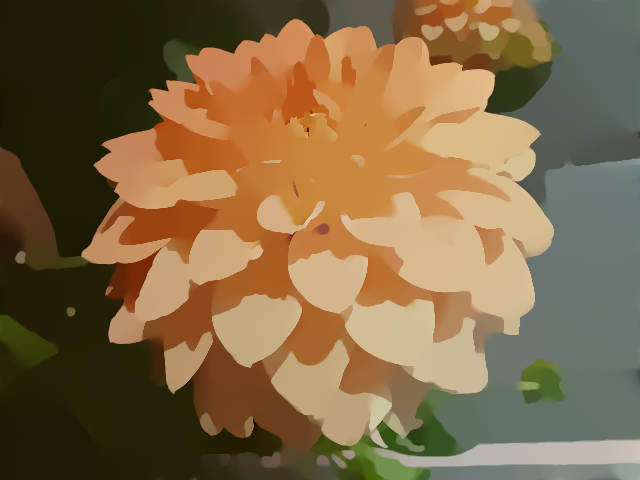

In [265]:
i

In [ ]:
print(tf.__version__)
print(dir(tf.scatter_update))

In [243]:
j = Image.open('out.png')

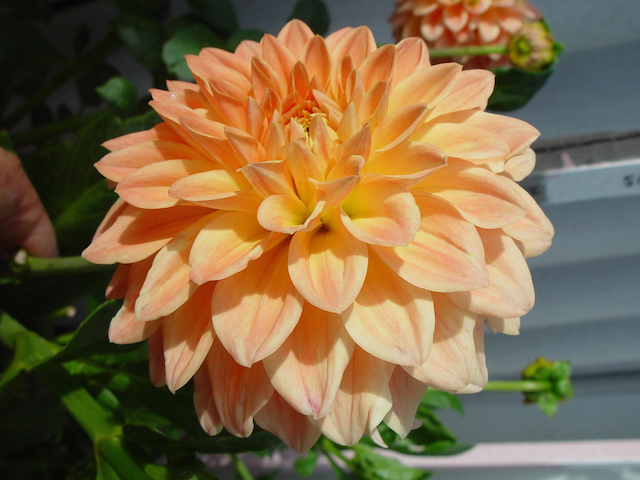

In [244]:
j

In [229]:
MTF = tf.math.square(otfFx) + tf.math.square(otfFy)


In [230]:
MTF

<tf.Tensor: id=48095, shape=(480, 640), dtype=complex128, numpy=
array([[ 0.00000000e+00+0.00000000e+00j, -9.63774366e-05-9.46213671e-07j,
        -3.85444723e-04-7.56916219e-06j, ...,
        -8.67006819e-04+2.55428447e-05j, -3.85444723e-04+7.56916219e-06j,
        -9.63774366e-05+9.46213671e-07j],
       [-1.71330172e-04-2.24283482e-06j, -2.67707609e-04-3.18904849e-06j,
        -5.56774896e-04-9.81199700e-06j, ...,
        -1.03833699e-03+2.33000099e-05j, -5.56774896e-04+5.32632737e-06j,
        -2.67707609e-04-1.29662114e-06j],
       [-6.85115197e-04-1.79403728e-05j, -7.81492633e-04-1.88865865e-05j,
        -1.07055992e-03-2.55095350e-05j, ...,
        -1.55212202e-03+7.60247193e-06j, -1.07055992e-03-1.03712106e-05j,
        -7.81492633e-04-1.69941591e-05j],
       ...,
       [-1.54073875e-03+6.05357903e-05j, -1.63711618e-03+5.95895766e-05j,
        -1.92618347e-03+5.29666281e-05j, ...,
        -2.40774557e-03+8.60786350e-05j, -1.92618347e-03+6.81049525e-05j,
        -1.63711618e-